In [1]:
using Base.Threads
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, guidefontsize=8, tickfontsize=6)

In [2]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx, disty; probtie=0.5)
    #s = max(std(distx), std(disty))
    #m = median(distx) - median(disty)
    #find_zero(a -> prob_x_le_y(distx, disty, a) - probtie,
    #    (amin, amax), Bisection())
    find_zero(a -> prob_x_le_y(distx, disty, a) - probtie, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [3]:
distx, disty = Gamma(6, 1), Gamma(2, 3)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (5.670161188712071, 5.035040970049984)
median(distx) - median(disty) = 0.6351202186620872
tieshift(distx, disty) = 0.6001914280974744


In [4]:
distx, disty = Uniform(), Chisq(1)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (0.5, 0.4549364231195729)
median(distx) - median(disty) = 0.045063576880427114
tieshift(distx, disty) = -0.02680686952216707


In [5]:

sprint(printcompact, Normal(√2))

LoadError: UndefVarError: printcompact not defined

In [6]:
function sim(TestFunc = MannWhitneyUTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6)
    pval = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval[i] = pvalue(TestFunc(X, Y))
    end
    pval
    ecdf(pval)
end

function printcompact(io, xs...)
    print(IOContext(io, :compact => true), xs...)
end

function distname(dist)
    replace(sprint(printcompact, dist), r"\{[^\}]*\}"=>"")
end

function plot_ecdf(ecdf_pval, TestFunc, distx, disty, m, n, a; kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:1)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    s = (a < 0 ? "" : "+") * string(round(a; digits=4))
    title!("$TestFunc\n\
        X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty))$s, n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(
        TestFunc1 = MannWhitneyUTest,
        TestFunc2 = UnequalVarianceTTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6, a = nothing, kwargs...)
    
    if isnothing(a)
        @show a = tieshift(distx, disty)
        @show prob_x_le_y(distx, disty + a)
    else
        @show a
        @show median(distx) - median(disty)
    end
    ecdf_pval1 = @time sim(TestFunc1;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax1 = ecdf_pval1(0.1)
    @show Δμ = mean(distx) - mean(disty)
    @show mean(distx), mean(disty + Δμ)
    ecdf_pval2 = @time sim(TestFunc2;
        distx = distx,
        disty = disty + Δμ,
        m, n, L, kwargs...)
    ymax2 = ecdf_pval2(0.1)
    ymax = max(ymax1, ymax2)
    P1 = plot_ecdf(ecdf_pval1, TestFunc1, distx, disty, m, n, a;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_pval2, TestFunc2, distx, disty, m, n, Δμ;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 450), topmargin=3.5Plots.mm)
end

plot_pvals (generic function with 3 methods)

## 正規分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.715435 seconds (7.98 M allocations: 2.010 GiB, 27.15% gc time, 25.84% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.574893 seconds (9.42 M allocations: 230.615 MiB, 42.66% compilation time)


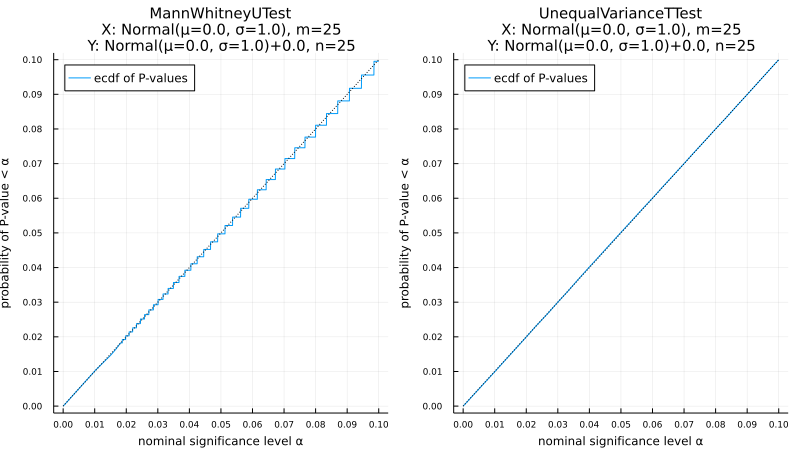

In [7]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  2.215043 seconds (7.00 M allocations: 2.690 GiB, 37.14% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.441304 seconds (9.00 M allocations: 206.012 MiB)


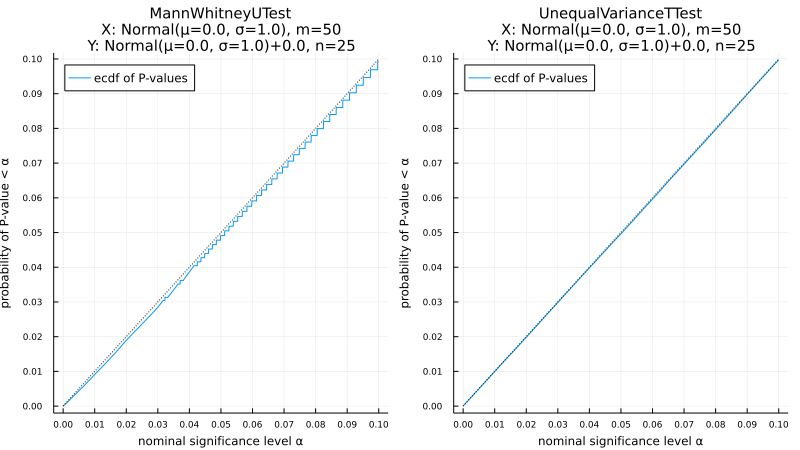

In [8]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 50, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.391238 seconds (7.00 M allocations: 1.960 GiB, 33.64% gc time, 0.23% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.408449 seconds (9.00 M allocations: 206.009 MiB, 18.39% gc time)


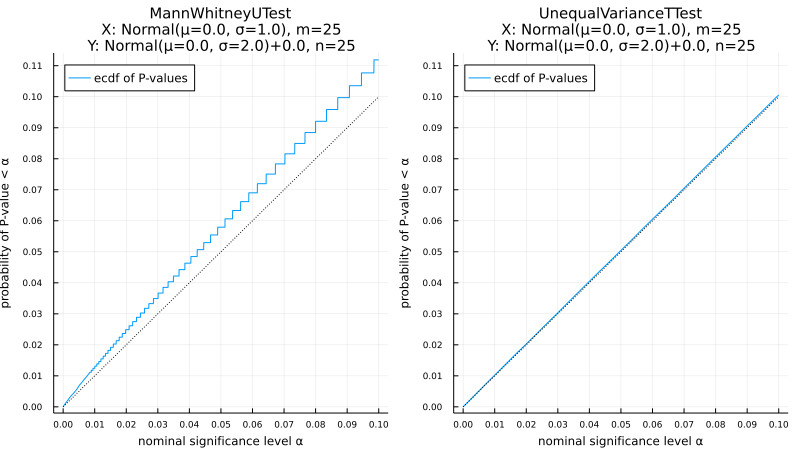

In [9]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.586395 seconds (7.00 M allocations: 2.690 GiB, 37.41% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.536475 seconds (9.00 M allocations: 206.012 MiB, 30.56% gc time)


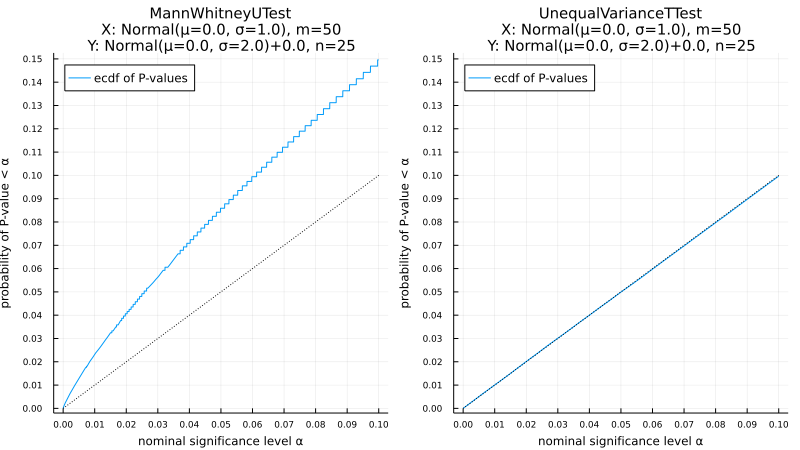

In [10]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.571253 seconds (7.00 M allocations: 1014.729 MiB, 24.21% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.477422 seconds (9.00 M allocations: 206.007 MiB, 37.01% gc time)


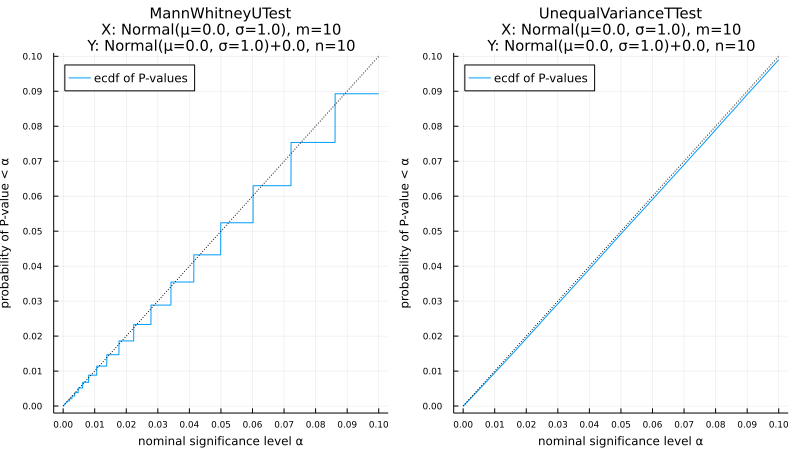

In [11]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.819543 seconds (7.00 M allocations: 1.289 GiB, 33.54% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.306696 seconds (9.00 M allocations: 206.007 MiB)


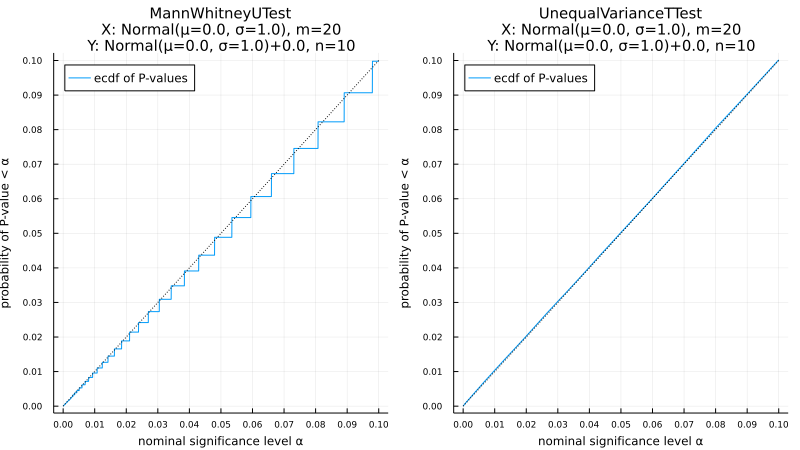

In [12]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 20, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.612876 seconds (7.00 M allocations: 1014.729 MiB, 26.44% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.502916 seconds (9.00 M allocations: 206.007 MiB, 37.02% gc time)


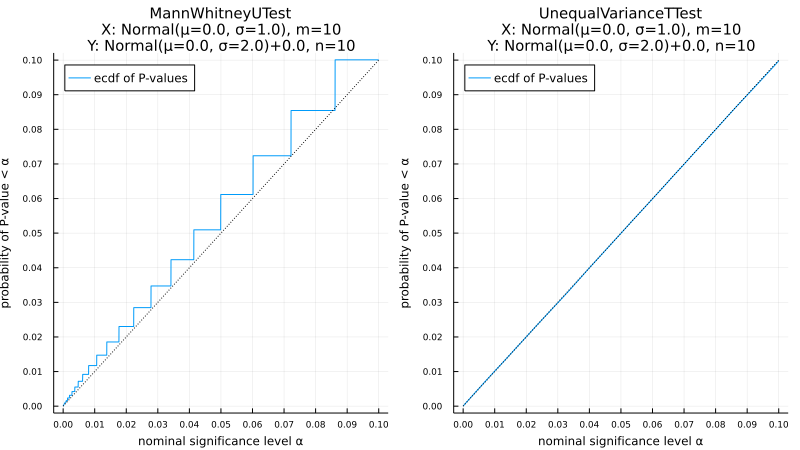

In [13]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.942359 seconds (7.00 M allocations: 1.289 GiB, 40.32% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.306415 seconds (9.00 M allocations: 206.008 MiB)


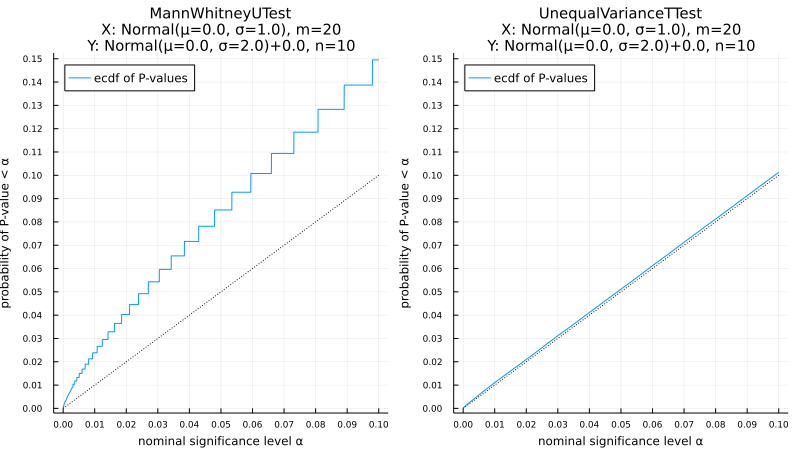

In [14]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 20, n = 10)

## ガンマ分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.675047 seconds (7.22 M allocations: 1.971 GiB, 22.15% gc time, 10.41% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.877657 seconds (9.07 M allocations: 211.142 MiB, 20.23% gc time, 9.85% compilation time)


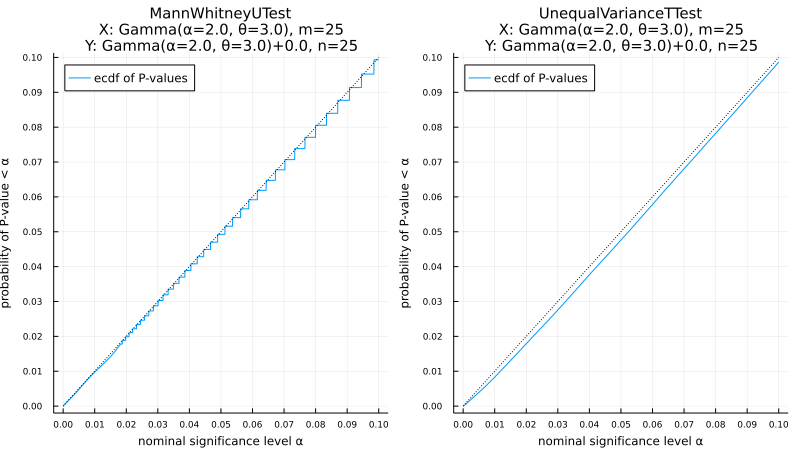

In [15]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.816636 seconds (7.00 M allocations: 2.690 GiB, 36.67% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.666218 seconds (9.00 M allocations: 206.012 MiB)


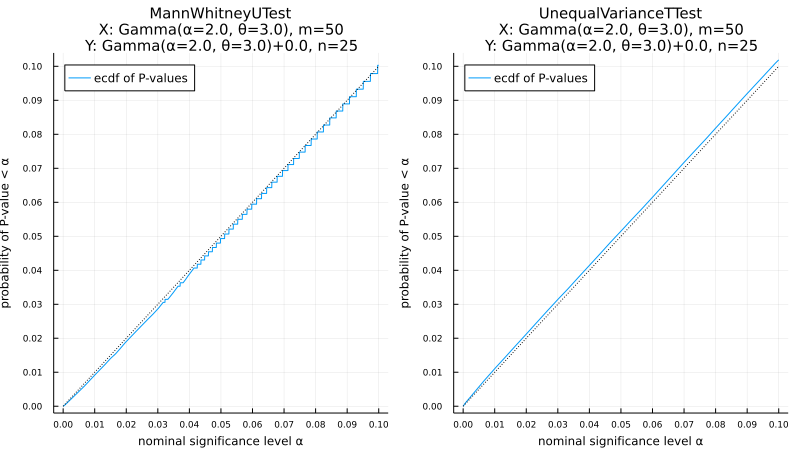

In [16]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.542539 seconds (7.00 M allocations: 1.960 GiB, 29.94% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.521303 seconds (9.00 M allocations: 206.009 MiB)


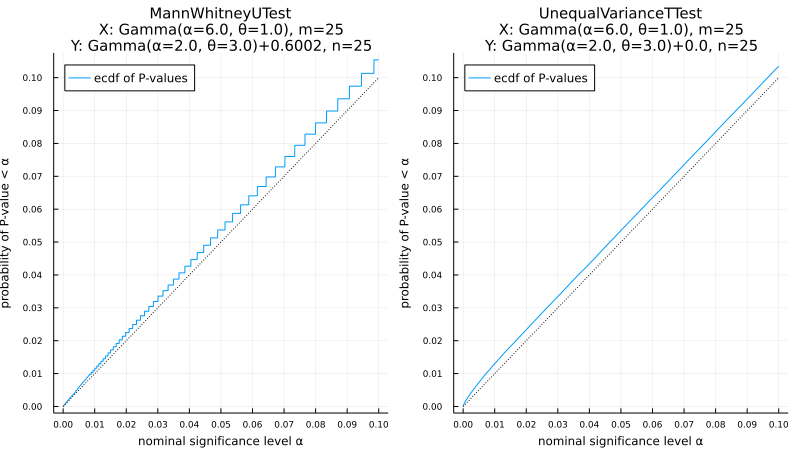

In [17]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.696265 seconds (7.00 M allocations: 2.690 GiB, 35.42% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.768286 seconds (9.00 M allocations: 206.012 MiB, 21.16% gc time)


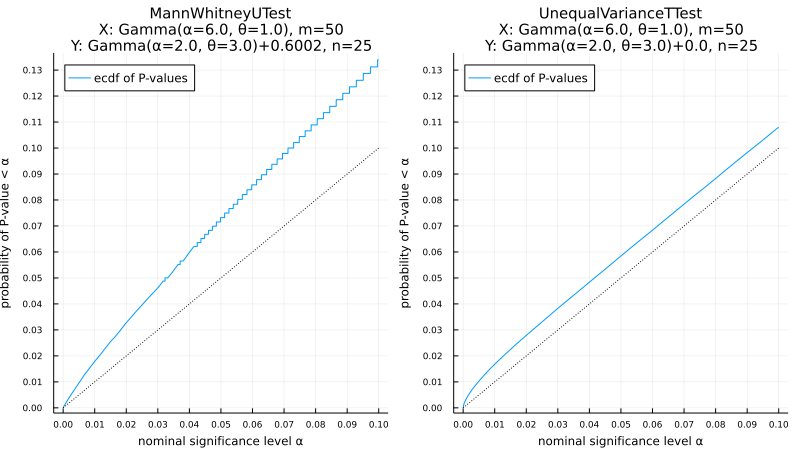

In [18]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.736810 seconds (7.00 M allocations: 1014.729 MiB, 28.32% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.394303 seconds (9.00 M allocations: 206.007 MiB)


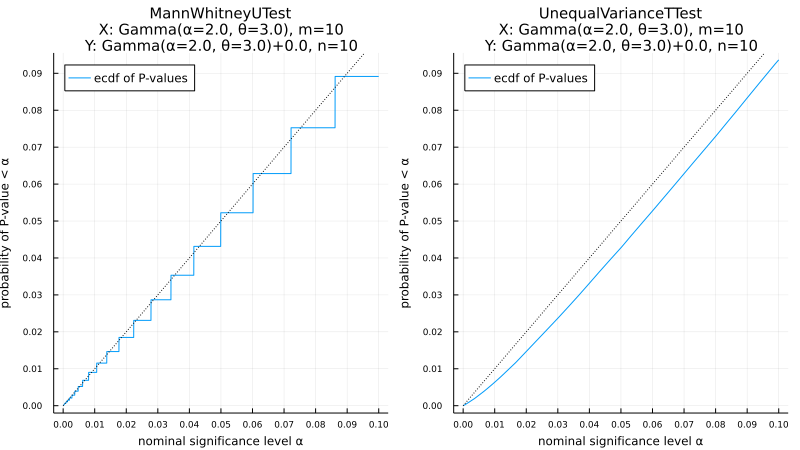

In [19]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.916828 seconds (7.00 M allocations: 1.289 GiB, 26.35% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.450597 seconds (9.00 M allocations: 206.008 MiB)


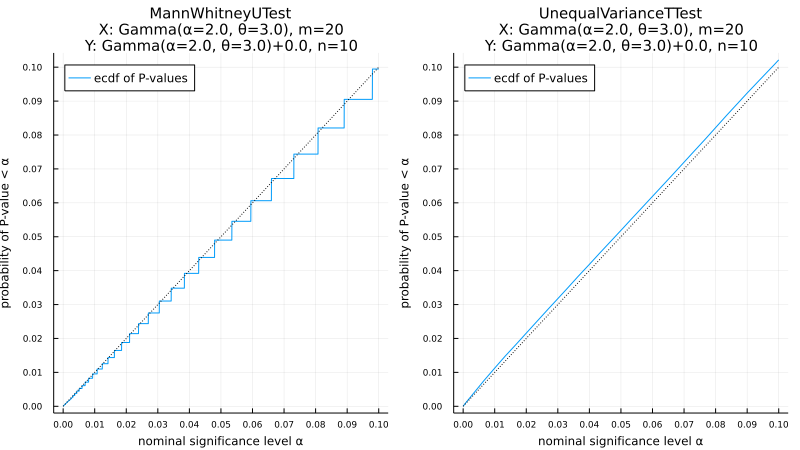

In [20]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 20, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  0.758173 seconds (7.00 M allocations: 1014.729 MiB, 34.80% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.429586 seconds (9.00 M allocations: 206.007 MiB)


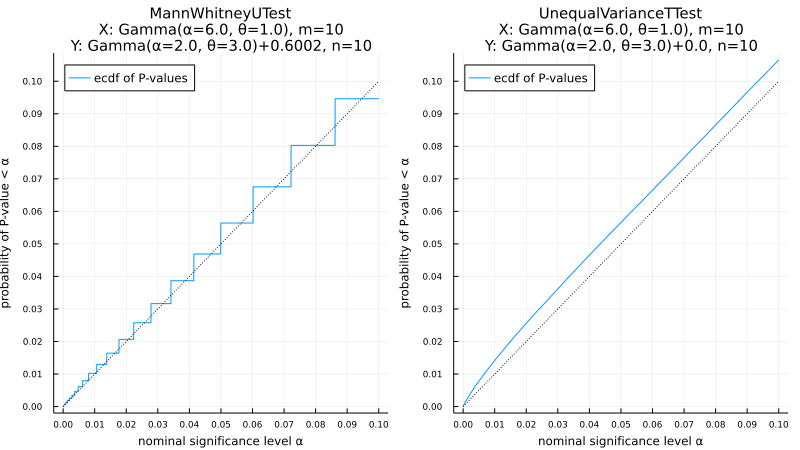

In [21]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.032616 seconds (7.00 M allocations: 1.289 GiB, 35.87% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.409363 seconds (9.00 M allocations: 206.007 MiB)


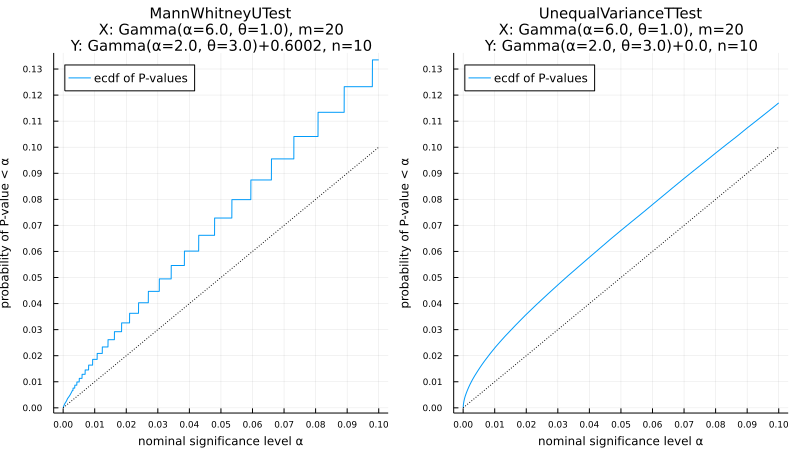

In [22]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 20, n = 10)

## 雑多

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.550053 seconds (7.06 M allocations: 1017.803 MiB, 12.76% gc time, 9.30% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.617844 seconds (9.07 M allocations: 211.198 MiB, 34.98% gc time, 13.59% compilation time)


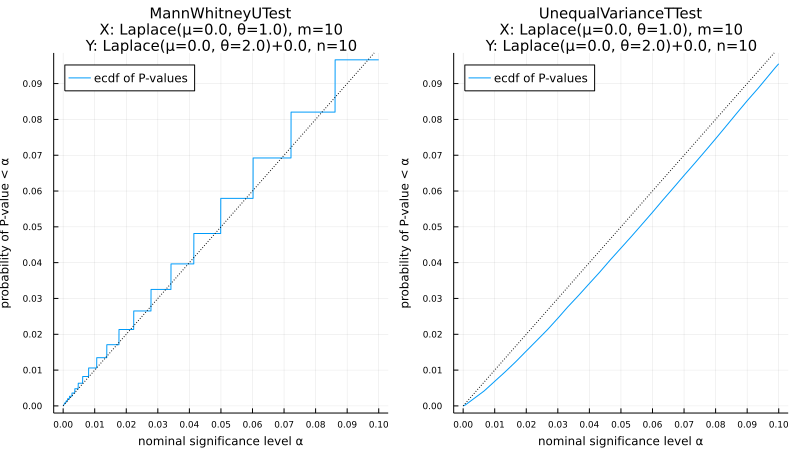

In [23]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.326376 seconds (7.00 M allocations: 1.960 GiB, 29.98% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.568404 seconds (9.00 M allocations: 206.009 MiB, 33.72% gc time)


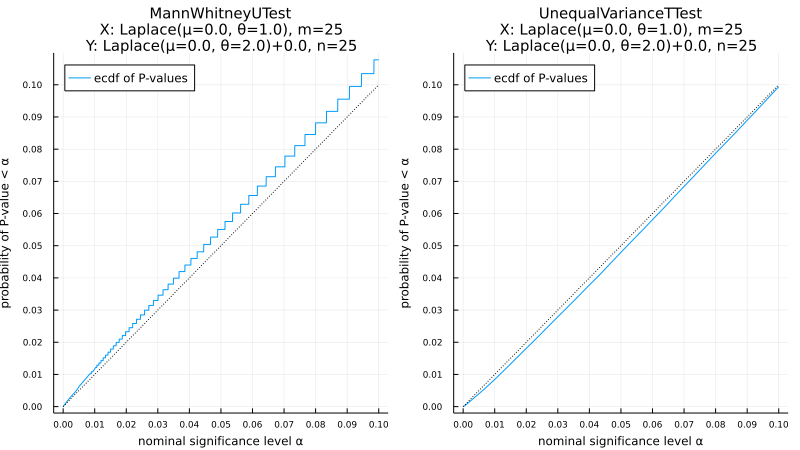

In [24]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  2.074169 seconds (7.00 M allocations: 3.539 GiB, 41.43% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.439236 seconds (9.00 M allocations: 206.015 MiB)


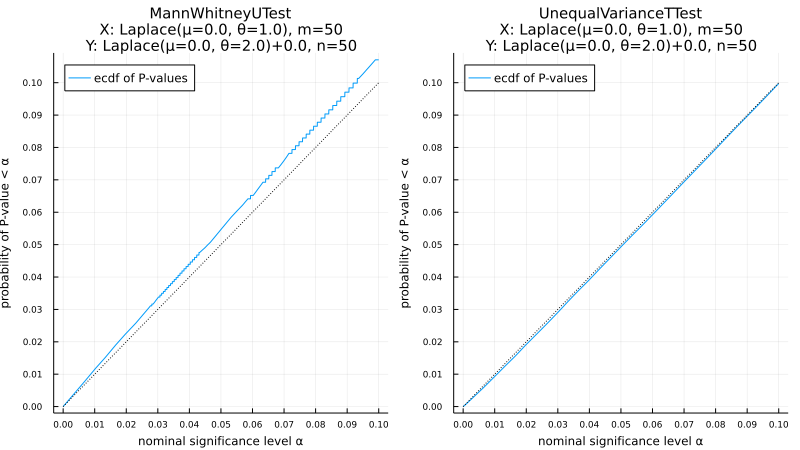

In [25]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 50)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.836547 seconds (7.00 M allocations: 1.289 GiB, 33.00% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.346219 seconds (9.00 M allocations: 206.008 MiB)


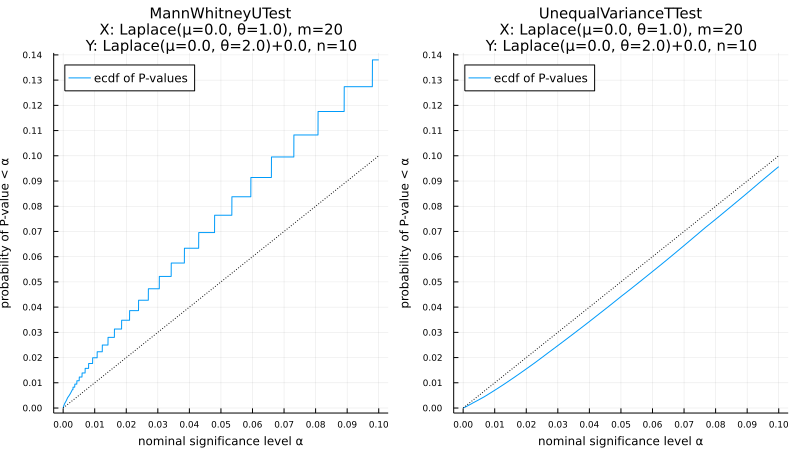

In [26]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.662890 seconds (7.00 M allocations: 2.690 GiB, 42.49% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.407610 seconds (9.00 M allocations: 206.012 MiB)


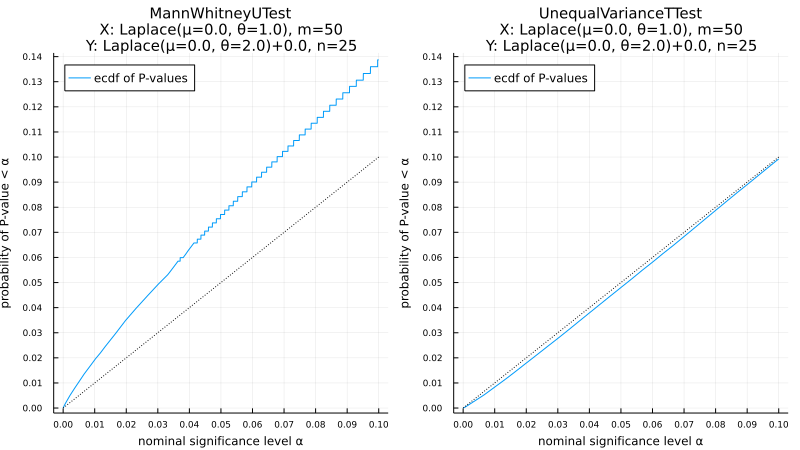

In [27]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.731569 seconds (7.59 M allocations: 1.018 GiB, 18.54% gc time, 25.57% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.482989 seconds (9.07 M allocations: 211.052 MiB, 22.67% gc time, 16.75% compilation time)


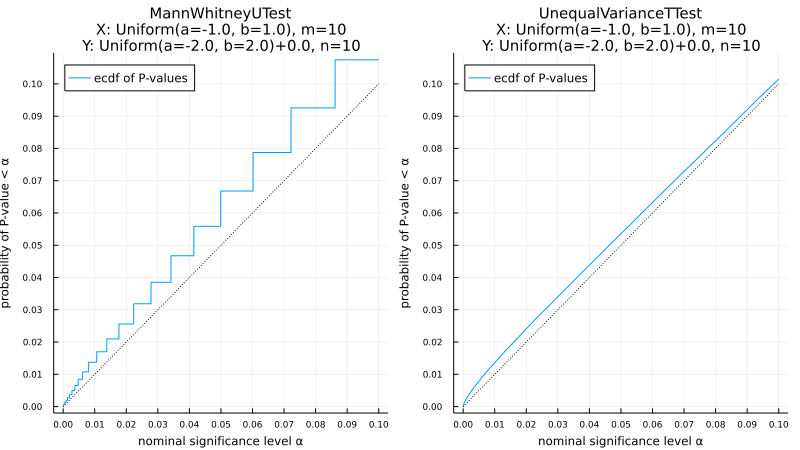

In [28]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.766721 seconds (7.00 M allocations: 1.289 GiB, 28.83% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.295593 seconds (9.00 M allocations: 206.007 MiB)


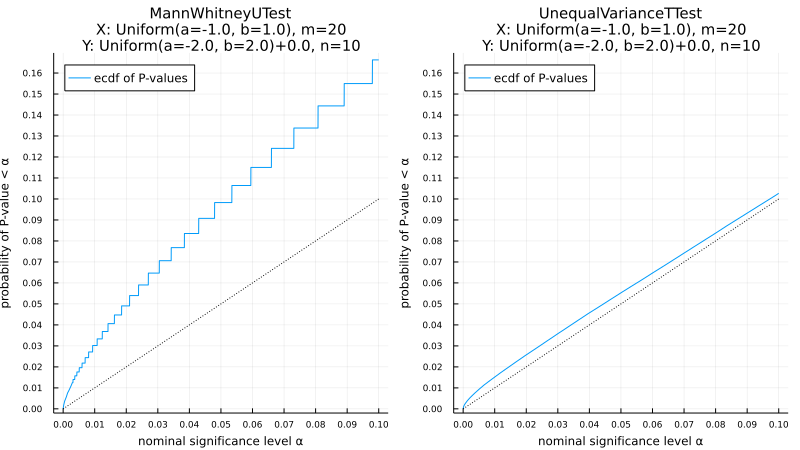

In [29]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.458587 seconds (7.00 M allocations: 2.690 GiB, 39.17% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.430198 seconds (9.00 M allocations: 206.012 MiB, 23.06% gc time)


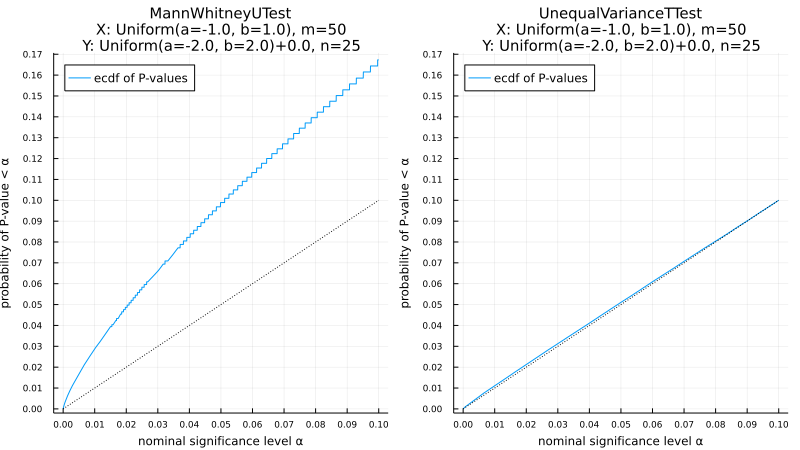

In [30]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 50, n = 25)

In [31]:
@doc LogNormal

```
LogNormal(μ,σ)
```

The *log normal distribution* is the distribution of the exponential of a [`Normal`](@ref) variate: if $X \sim \operatorname{Normal}(\mu, \sigma)$ then $\exp(X) \sim \operatorname{LogNormal}(\mu,\sigma)$. The probability density function is

$$
f(x; \mu, \sigma) = \frac{1}{x \sqrt{2 \pi \sigma^2}}
\exp \left( - \frac{(\log(x) - \mu)^2}{2 \sigma^2} \right),
\quad x > 0
$$

```julia
LogNormal()          # Log-normal distribution with zero log-mean and unit scale
LogNormal(μ)         # Log-normal distribution with log-mean mu and unit scale
LogNormal(μ, σ)      # Log-normal distribution with log-mean mu and scale sig

params(d)            # Get the parameters, i.e. (μ, σ)
meanlogx(d)          # Get the mean of log(X), i.e. μ
varlogx(d)           # Get the variance of log(X), i.e. σ^2
stdlogx(d)           # Get the standard deviation of log(X), i.e. σ
```

External links

  * [Log normal distribution on Wikipedia](http://en.wikipedia.org/wiki/Log-normal_distribution)


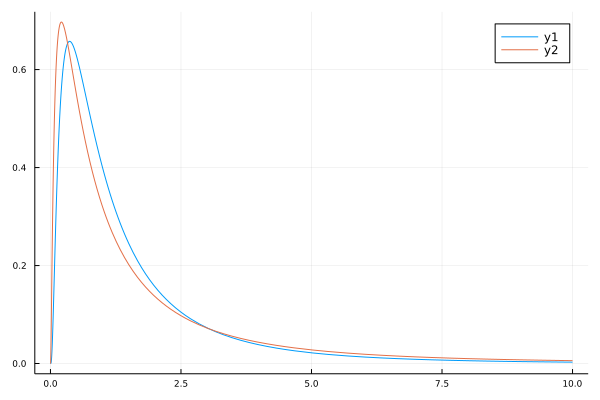

In [32]:
plot(LogNormal(0, 1), 0, 10)
plot!(LogNormal(0, 1.25), 0, 10)

In [33]:
std(LogNormal(0, 1)), std(LogNormal(0, 1.25))

(2.1611974158950877, 4.241363213821604)

a = tieshift(distx, disty) = 7.873419302111289e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.712551 seconds (753.05 k allocations: 3.060 GiB, 35.73% gc time, 3.08% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.334427 seconds (974.24 k allocations: 25.909 MiB, 27.05% compilation time)


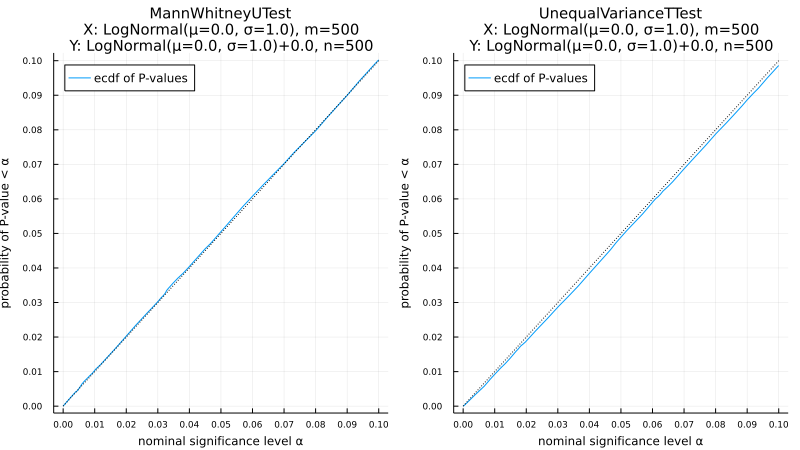

In [34]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  1.739036 seconds (700.20 k allocations: 3.057 GiB, 38.51% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.268803 seconds (899.70 k allocations: 20.704 MiB)


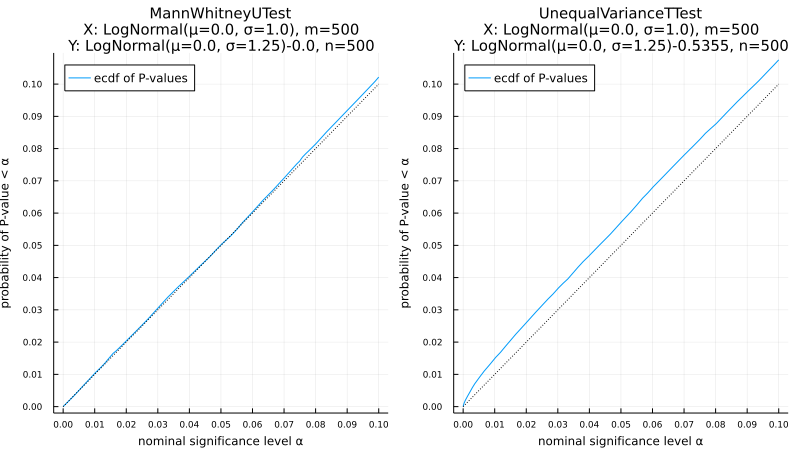

In [35]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  2.647980 seconds (700.21 k allocations: 4.553 GiB, 39.16% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.368283 seconds (899.69 k allocations: 20.750 MiB)


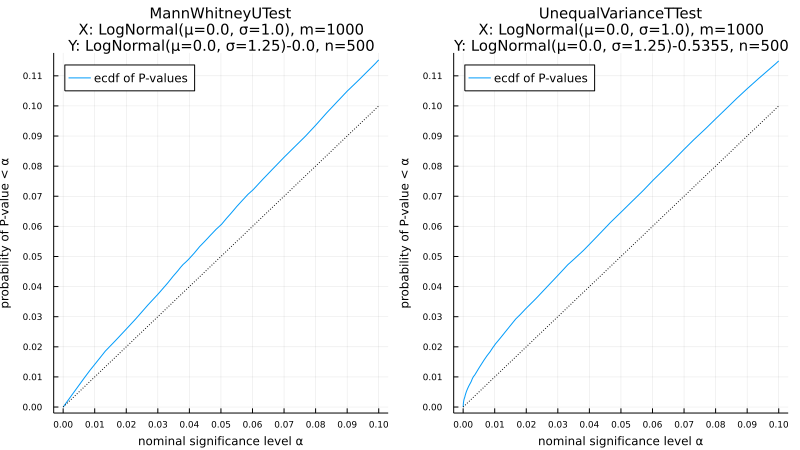

In [36]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 1000, n = 500, L=10^5)

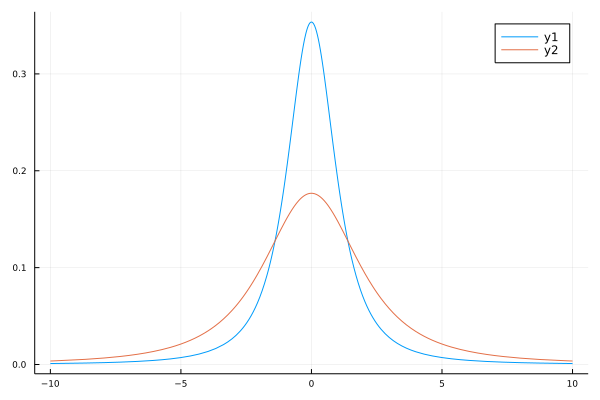

In [37]:
plot(TDist(2), -10, 10)
plot!(2TDist(2), -10, 10)

In [38]:
var(TDist(2)), var(TDist(3)), var(TDist(4)), var(TDist(5))

(Inf, 3.0, 2.0, 1.6666666666666667)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  4.806284 seconds (7.15 M allocations: 6.840 GiB, 38.41% gc time, 1.58% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.223777 seconds (9.07 M allocations: 211.228 MiB, 10.81% compilation time)


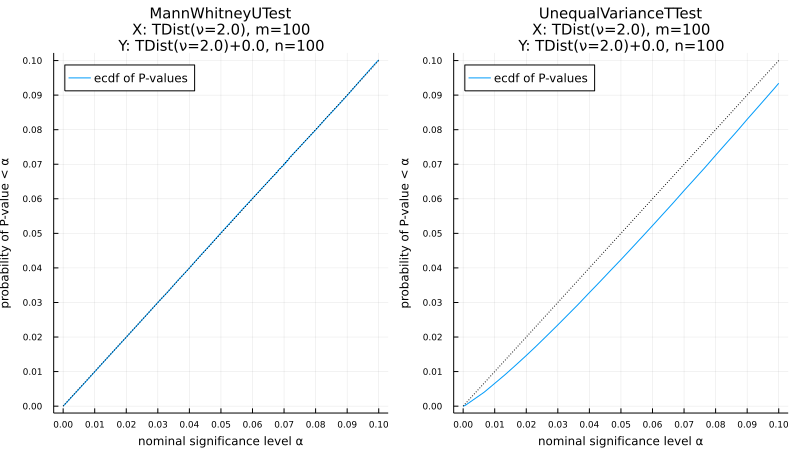

In [39]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  5.928375 seconds (7.00 M allocations: 9.783 GiB, 38.21% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.476251 seconds (9.00 M allocations: 206.034 MiB)


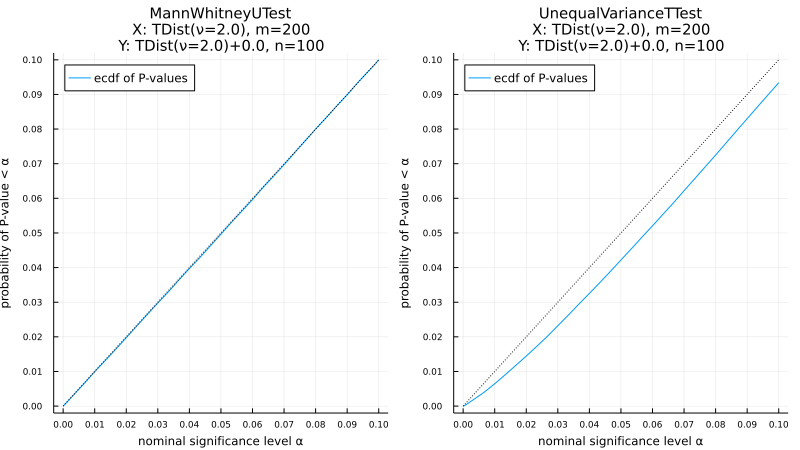

In [40]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 200, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  4.280281 seconds (7.00 M allocations: 6.832 GiB, 36.16% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.306506 seconds (9.00 M allocations: 206.024 MiB, 14.24% gc time)


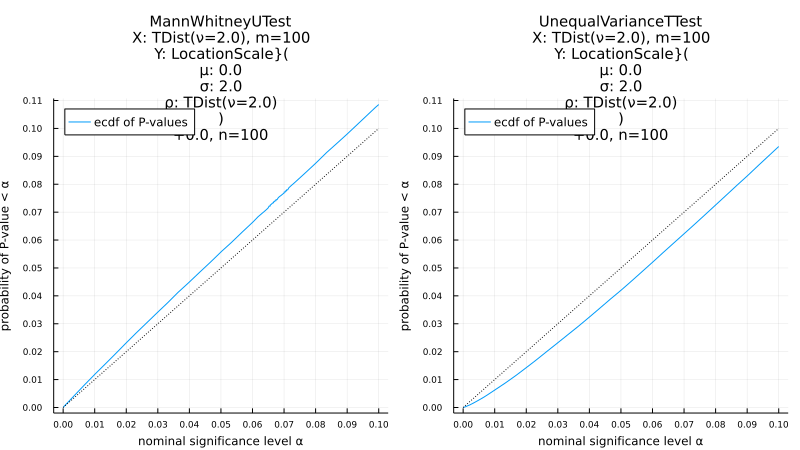

In [41]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  5.571166 seconds (7.00 M allocations: 9.783 GiB, 35.23% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.510051 seconds (9.00 M allocations: 206.034 MiB, 2.15% gc time)


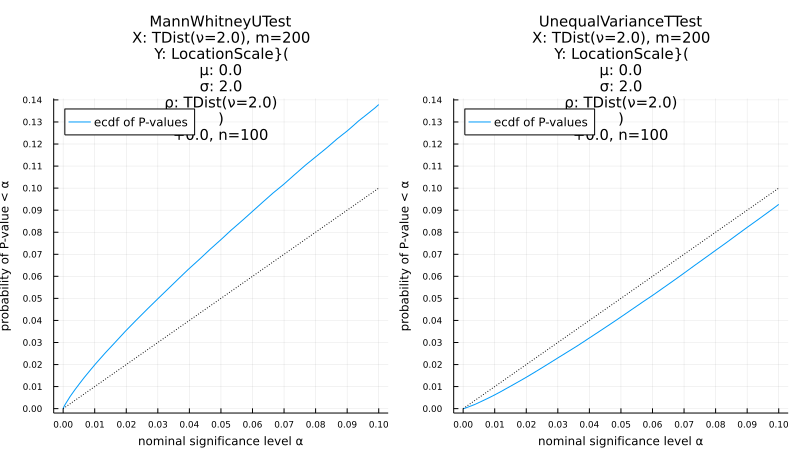

In [42]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 200, n = 100)

## median matching vs. tie shifting

a = tieshift(distx, disty) = -0.8414056600399943
  4.087299 seconds (7.19 M allocations: 6.842 GiB, 44.15% gc time, 1.87% compilation time)
a = median(distx) - median(disty) = -0.6931471805599453
  4.005384 seconds (7.00 M allocations: 6.832 GiB, 44.29% gc time)


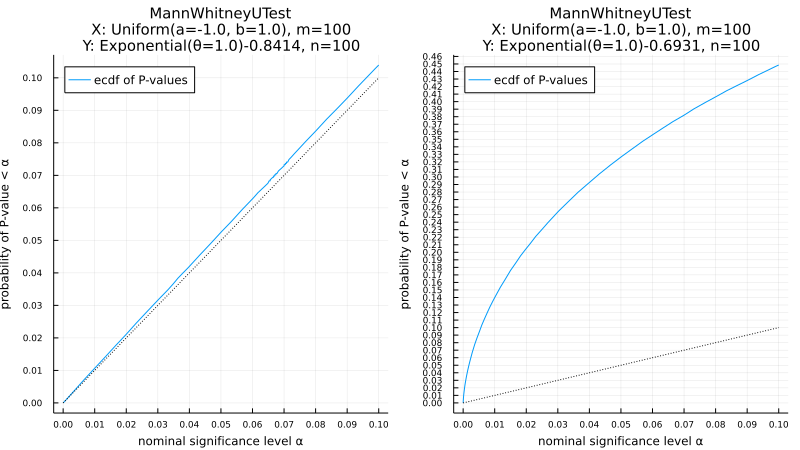

In [43]:
distx, disty = Uniform(-1, 1), Exponential()
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=1.0), 1.0)
tieshift(distx, disty) = -0.8414056600399943
median(distx) - median(disty) = -0.6931471805599453


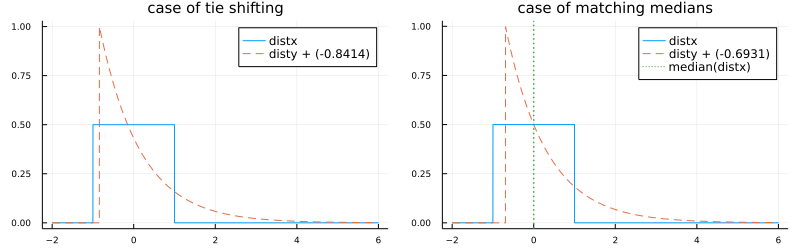

In [44]:
distx, disty = Uniform(-1, 1), Exponential()
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

a = tieshift(distx, disty) = -2.814168911097315
  4.093390 seconds (7.00 M allocations: 6.832 GiB, 43.87% gc time)
a = median(distx) - median(disty) = -2.772588722239781
  4.270949 seconds (7.00 M allocations: 6.832 GiB, 42.28% gc time)


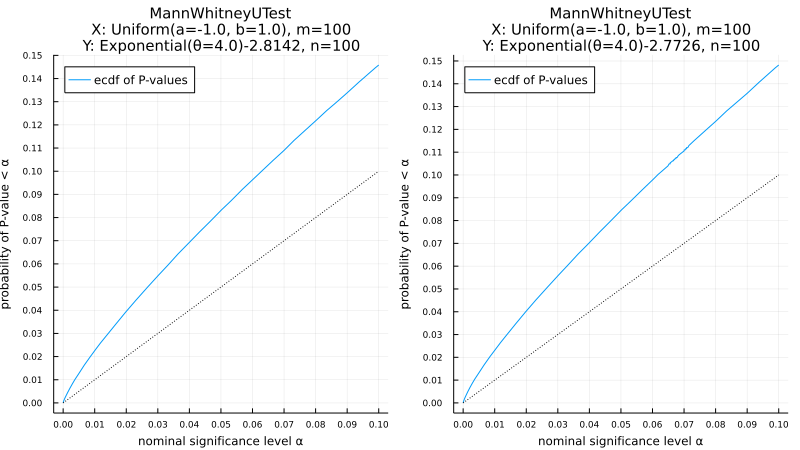

In [45]:
distx, disty = Uniform(-1, 1), Exponential(4)
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=4.0), 4.0)
tieshift(distx, disty) = -2.814168911097315
median(distx) - median(disty) = -2.772588722239781


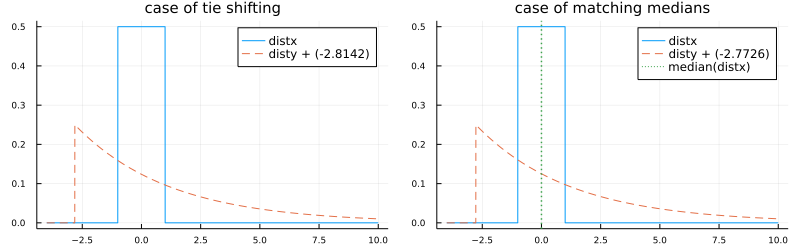

In [46]:
distx, disty = Uniform(-1, 1), Exponential(4)
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

a = tieshift(distx, disty) = -0.5370568188698568
  4.118363 seconds (7.00 M allocations: 6.832 GiB, 43.15% gc time)
a = median(distx) - median(disty) = -0.40018871128431455
  4.093318 seconds (7.00 M allocations: 6.832 GiB, 44.89% gc time)


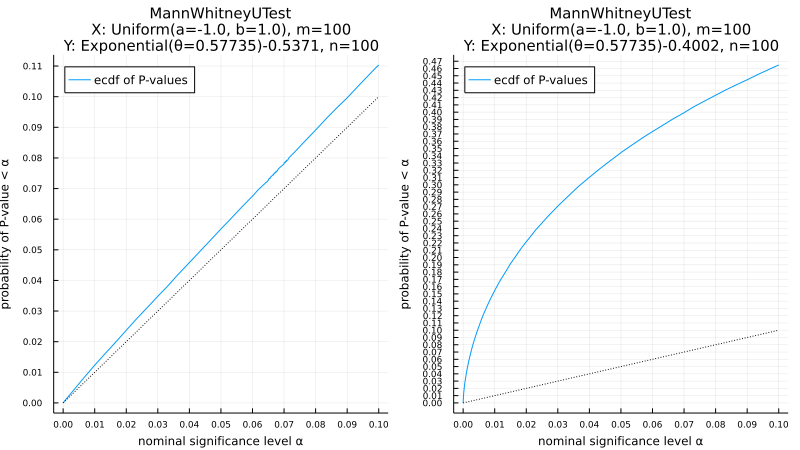

In [47]:
distx, disty = Uniform(-1, 1), Exponential(0.5773502691896257)
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=0.5773502691896257), 0.5773502691896257)
tieshift(distx, disty) = -0.5370568188698568
median(distx) - median(disty) = -0.40018871128431455


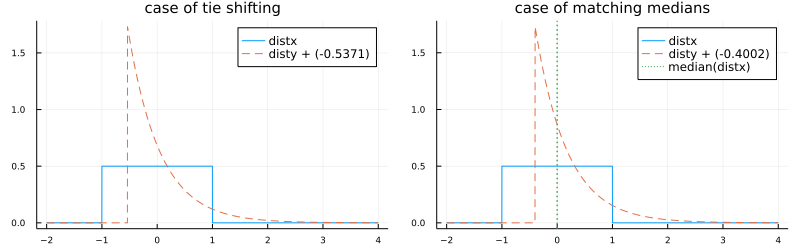

In [49]:
distx, disty = Uniform(-1, 1), Exponential(0.5773502691896257)
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 4; label="distx")
plot!(disty + a, -2, 4; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 4; label="distx")
plot!(disty + a, -2, 4; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))